## Background

### Evaluating CSF movement in the cranium
The brain is unique from other organs, in that despite its high metabolic demands, it lacks a traditional lymphatic system. Because of this, long standing questions remain unanswered regarding the mechanisms by which waste proteins are eliminated. Recently it has been proposed that waste clearance may be facilitated in part, by the exchange of cerebrospinal fluid (CSF) through the brain parenchyma in a process called "glymphatic exchange". As this is a relatively young hypothesis that requires intact cranial anatomy to study, abundant questions remain regarding the mechanisms by which this exchange is facilitated.

Image from Rasmussen et al. 2018

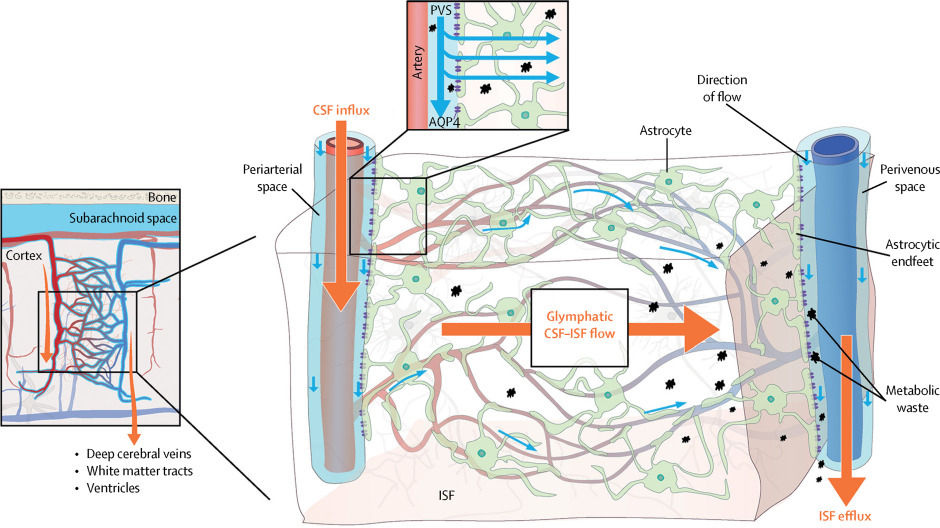


To study the exchange of CSF into the brain, the earliest studies relied on the injection of fluorescent tracers into the CSF compartment followed by confocal imaging of fixed tissue slices. Though this approach provides excellent spatial resolution, it lacks temporal information, as well as the capacity for high throughput assessment of regional differences.

To address these issues, dynamic contrast enhanced magentic resonance imaging (DCE-MRI) has become a common alternative to fluorescent tracer studies. In these studies a contrast agent (ex: gaditeridol) is injected into the CSF rather than the fluorescent tracer, and is serially scanned across several timepoints. We will take a look at DCE-MRI data demonstrating cranial distribution of gaditeridol at 10 minute intervals across 90 minutes immediately following infusion into the CSF. If there is time, at the end of today's dataset we will begin to evaluate the role of an astrocytic gene (Snta1) in facilitating brain CSF influx kinetics, using a transgenic mouse line (ASYN).

With regard to processing MRI data, today we will go through the following steps:

1. Importing MRI data (with nibabel).
2. Visualizing 2D slices of MRI data.
3. Masking and 'registering' MRI data with an anatomical atlas.
4. Extracting 3D voxel intensities in regions of interest and plotting it.


Image from Iliff et al. 2012

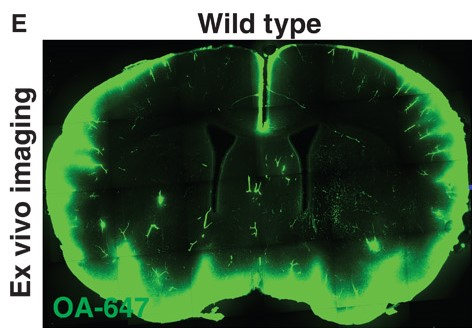

### DCE-MRI data
As MRI data is acquired, it can be stored in many formats (Bruker, DICOM, etc.) that often include both the image data, as well as metadata describing the MRI scan parameters. Ultimately, MRI data will often be stored and used as Neuroimaging Informatics Technology Initiative (NIFTI) files with the extension .nii or .nii.gz. One advantage of this format is that the voxel data is stored as a multi-dimensional array, so it can be easily worked with using languages such as Python and R, and it allows us to work with highly dimensional data like that acquired using MRI. 

NIFTI files can be opened using image analysis programs like FIJI, but often they contain so much data that it is impractical to work with them in these programs due to hardware demands.

## Getting Started

### Import Libraries

First, we will import the libraries that we need. This will include libraries that we have worked with extensively already (NumPy, SciPy, Matplotlib, etc.), as well as one we have not used before: Nibabel. Nibabel is useful for reading and working with NIFTI filetypes.

Run the following code block to import these libraries.

In [ ]:
import nibabel as nib
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
%matplotlib inline

### Import data

Now let's go ahead and import the first set of data that we will work with. We will begin by opening and looking at unregistered data from a wild-type animal.

The data has been stored as a NIFTI file, so you will need to use nibabel to import this file.

Load the file 'WT_unregistered.nii.gz' and save the result in a variable `WT_original`. 

*hint* use `nib.[tab]` to identify functions potentially useful for loading the data.


Once you have the file loaded, try to learn a little more about what `WT_original` is. Is it an array? Is it an instance of a special class provided by nibabel? Use `WT_original.[tab]` to explore what methods and attributes are available on the object. Once you have figured out what type of object `WT_original` is, find out what the shape of the data stored in the object is.


In [ ]:
# Answer
WT_original = nib.load('WT_unregistered.nii.gz')
display(WT_original.shape, type(WT_original))

### Exercise 1: Extracting array data

As you can see `WT_original` is an instance of the Nifti1Image class and supports certain array-like methods and attributes (e.g., shape is one, allowing you to view the shape of the data stored within). This tells us that it has four dimensions. The first three are spatial dimensions and the last one is time. With MRI data, we can "slice" the image along any of the 3 axis to give us different views of the brain. This means that we can look at the data along the following axes:

1. Coronal
2. Transverse (Axial)
3. Sagittal
4. Time

As I mentioned before, the images were acquired at 10 minute intervals for 90 minutes. That means that our ten values on the time axis correspond to the baseline (the first slice of the time axis), then each 10 minute interval.

Below is a schematic of what the spatial planes represent.

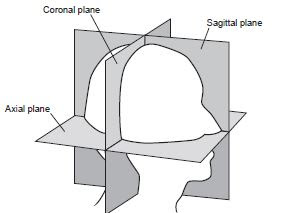

A nice feature of nibabel is that it doesn't actually load the full dataset into memory until you need it. The load function returns a Nifti1Image object that allows you to view information about the file. When you finally need the data, you can then extract it from the object.

Try to use another nibabel method to extract the array data and save this as `WT_original_data`. Again, display the shape and type of the data.

In [ ]:
# Answer
WT_original_data = WT_original.get_data()
display(WT_original_data.shape, type(WT_original_data))

## Visualizing MRI data
### Exercise 2: A peak at our data
Use matplotlib to quickly get a look at our data. Let's look along the saggital axis (the 3rd dimension) to get an idea of where the brain resides within our array. Let's also look at the baseline image (slice 0 in the 4th dimension).

the matplotlib function `imshow`, will allow us to quickly visualize a 2D array extracted from the MRI data.

Useful info: The previous exercise showed us that there are 192 slices along the sagittal axis of our scan. Because the brain should be generally in the middle of the scan area, let's plot a 2 dimensional baseline image located in the middle of the sagittal plane (try around the 90th slice) to get a view around the middle of the brain.

Sidenote: Even more so than in fluorescence images, the color you use is arbitrary since you are not actually measuring fluorophores. The default color is kind of nice. If you want it to look like MRI data you see in publications use `'gray'` for the color map.

**Bonus** Making a more sophisticated plot: If you feel like practicing your matplotlib skills, you can dress up your plot by adding a title 'Sagittal slice', as well as x and y axis labels for the 'transverse' and 'coronal' axes.

**Double Bonus** Play around with altering the particular slice from which the image is generated and replot or use subplots to get familiar with where our data of interest sits in the array.

In [ ]:
# Answer
plt.imshow(WT_original_data[:,:,90,0], cmap='gray')
plt.title('Sagittal slice')
plt.xlabel('Coronal position')
plt.ylabel('Transverse position')

In order to get a 2D image with our data, you need to specify a single plane for two of the axes. For example if you were to have plotted:
        
        WT_original_data[:, :, :, 0]
        
You would have returned a 3D (i.e., cube) array that gives you a complete representation of the image at baseline.

The array we plotted above slices that cube along a single plane so that we can visualize it.
    

### Exercise 3: A quick survey of our data
Ultimately pulling single slices will be how the data is presented in a figure, but to take full advantage of the MRI data we will need to evaluate across many slices. To start this process, let's first take a quick look at several slices along an axis to get an idea of what we are working with. This will also allow us to confirm which axis is tied to which dimenson of our data. Let's do this by sampling four images, at the same time.

Matplotlib features a method that will allow us to look at several slices from each axis in a single plot. 

To accomplish this, the first step is to generate a figure with space for four seperate images. This is done using the `plt.subplots` method, which creates a grid (specifically, a 2D numpy array) of axes objects which can each be titled and defined. Since it's an array, you can index it like one to obtain a reference to the axes you want to use for plotting. In the previous class, you worked extensively with the object-oriented interface of Matplotlib. If you need a refresher, please look back at some of the cells in the previous class that generated plots using `plt.subplots`.

Once you have done this, you can then populate each axes with the method `plt.imshow`, drawing inspiration from the previous exercise.

Plot 4 images across the first dimension of the array. Our `.shape` function in the first exercise showed us that there are 192 slices in the first axis. Eyeballing the y-axis of the plot from the last exercise shows us that the brain is found roughly between the 25-80th slices. Plot the 30th, 45th, 60th and 75th slices. Let's again plot these all from the baseline scan (which is the 0 position in the 4th dimension of the array)
    
Useful info: For creating the subplot, save the returned figure in a variable, `figure_1` and the subplots as `axes`. Make a 2 x 2 subplot grid (2 columns and 2 rows). Since we are plotting several images at once, make the figure size a bit larger to make sure we can see the images well (try 10 for the width and height). Though the axis labels were useful when plotting a single image, the image array we are about to create is purely designed to give us an overview of our data. As a result, let's also get rid of the axis labels to prevent cluttering of our figure.

In [ ]:
# Answer
slice1 = WT_original_data[30,:,:,0]
slice2 = WT_original_data[45,:,:,0]
slice3 = WT_original_data[60,:,:,0]
slice4 = WT_original_data[75,:,:,0]

figure_1, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axes[0,0].imshow(slice1, cmap='gray')
axes[0,1].imshow(slice2, cmap='gray')
axes[1,0].imshow(slice3, cmap='gray')
axes[1,1].imshow(slice4, cmap='gray')

#We discussed ravel last week. Here we use it to generate 
#a flattened array that contains each axes, 
#which we can then apply a for loop to.
for ax in axes.ravel():
    ax.axis('off')

We see now that slicing the data in the first axis will give us a horizontal slice of the brain. We also saw in the second exercise that the slicing along the third axis will generate a saggital view of the brain, therefore a slice along the second axis will provide a coronal section of the tissue. We also now have a general idea of which voxels roughly correspond to the brain within our 3-dimensional space.

### Exercise 3: Defining a function to create a summary of time course changes.

With regard to evaluating CSF exchange in the brain, the real advantage of MRI data is the temporal element. We can use a similar approach to what we just did to quickly plot a single slice at each timepoint. This is useful for quickly summarizing changes.

There are a few ways to set this up.

*hint* Try building a function that will work through each of the timepoints and add them to a subplot.

In [ ]:
# Answer
def show_slices(slices):
    figure_2, axes = plt.subplots(nrows=1, ncols=len(slices), figsize=(2*len(slices), 2))
    for ax, slice in zip(axes, slices):
        ax.imshow(slice, cmap='gray')
        ax.axis('off')
        
# In this method we manually generate the slices, then apply our function to a list of slices
slice_0 = WT_original_data[:,:,90,0]
slice_1 = WT_original_data[:,:,90,1]
slice_2 = WT_original_data[:,:,90,2]
slice_3 = WT_original_data[:,:,90,3]
slice_4 = WT_original_data[:,:,90,4]
slice_5 = WT_original_data[:,:,90,5]
slice_6 = WT_original_data[:,:,90,6]
slice_7 = WT_original_data[:,:,90,7]
slice_8 = WT_original_data[:,:,90,8]
slice_9 = WT_original_data[:,:,90,9]
show_slices([slice_0, slice_1, slice_2, slice_3, slice_4, slice_5, slice_6, slice_7, slice_8, slice_9])
plt.suptitle("Saggital Time Series");

#OR

# Generate a 3D array of the same sagittal slice over time, 
# then use a for loop to insert the dataframe at each timepoint into the subplot array
slices = WT_original_data[:, :, 90, :]
    
def show_slices(slices):
    n_timepoints = slices.shape[-1]
    figure_width = 2*n_timepoints
    figure_height = 2
    figure_4, axes = plt.subplots(1, n_timepoints, figsize=(figure_width, figure_height))
    for i, ax in enumerate(axes):
        ax.imshow(slices[..., i], cmap='gray')
        ax.axis('off')
        
show_slices(slices)

## Manipulating MRI data

### Exercise 4: Masking everything outside of the brain
If you look closely at the images from the previous exercise, you can see that there is some movement discrepancies in the orientation of the brain. This is likely a result of subtle shifting of the mouse within the bore of the magnet across the imaging period. This can be an issue if we are attempting to quantify changes in signal intensity across the imaging period.

To address this, we need to register the images to each other. One way to accomplish this is by identifying landmark structures within the brain (ventricles, major blood vessels, etc.), and adjusting the voxel array according to the magnitude of the shift between these landmark structures (more on this later). The effectiveness of this process is greatly impacted if the landmark structures shift in a non-uniform way. Fortunately the brain is highy ridgid within the skull, but other elements of the head are not, including the toungue which can cause issues during registration.

To maximize registration accuracy, we will next apply a binary mask to the images to eliminate all pixels outside of the brain. This mask has been created outside of Python.

Load the mask data as `WT_mask` from the file `WT_mask.nii.gz`, extract the numpy array from the `WT_mask` object, and display the shape of the result.

In [ ]:
# Answer
WT_mask = nib.load('WT_mask.nii.gz')
WT_mask_data=WT_mask.get_data()
display(WT_mask_data.shape)

Note that the mask only has 3 array elements, as there is no time element.

### Exercise 5: Applying the mask to our MRI data

Now that we have loaded the mask we now want to apply it to our data array. As we have seen before, masks allow you to extract a subset of an array by providing a mask that's of the same shape as the array (there are exceptions, which we will discuss in a minute). The mask must be of boolean type. As a refresher, what is the result of the following? What's in `subset`?:

    x = np.array([1, 1, 2, 3, 5, 8, 13])
    mask = np.array([False, False, False, True, False, False, True])
    subset = x[mask]

What is the type of `WT_mask_data` array? Is it boolean? Integer? How do you figure out the data *type*(hint)? If it's not boolean, how do you convert it? You want it *as* (hint) a boolean array. If you need to convert it, please save the converted data as `WT_mask_bool`.

Let's also take a look at what the mask actually looks like. Plot a slice of the mask using `.imshow`, and be mindful of the dimensions!

In [ ]:
# Answer
WT_mask_bool = WT_mask_data.astype('bool') 
plt.imshow(WT_mask_bool[:, :, 90], cmap='gray')

How did numpy know to convert 0 to False and 1 to True? This is based on *truth value testing* (https://docs.python.org/3/library/stdtypes.html#truth). All objects in Python can be evaluated as a boolean value. For example, if you evaluate an empty list, (i.e., `bool([])`), it will return False. If you evaluate a non-empty list (i.e., `bool([1, 2, 3])`) it will return `True`. For integers, 0 is considered False and a non-zero value is considered True.
    
We are going to modify the MRI data using the mask. To ensure we still have access to the unmodified MRI data, we are going to make a *copy* of `WT_original_data` and work with the copy for the next few steps. Please go ahead and make a copy. Ensure it is a *copy* of the data, not a *view* (we discussed the difference between a copy and a view last week). Save the copy as `WT_masked_data`.

In [ ]:
# Answer
WT_masked_data = WT_original_data.copy()

Now apply the mask to the data and name the result `WT_mask_applied`. Earlier, we mentioned that the mask array must be the same shape as the array we would like to apply it to. However, don't worry about the difference in shape for now. Just try to use it as-is. What happens? What is the shape of `WT_mask_applied`? And how does it compare to the shape of the unmasked data?

In [ ]:
# Answer
WT_mask_applied = WT_masked_data[WT_mask_bool]

display(WT_masked_data.shape)
display(WT_mask_applied.shape)

Note that we've gone from four dimensions to two. What's special about the number `736284`? Why does applying a mask drop extra dimensions? Think about the following example where we have a 2D array and mask (run the code block below to see):
    
    x = np.array([[1, 2], 
                  [3, 4]])
    
    m = np.array([[True,  True],
                  [False, True]])
    
    y = x[m]

Given the mask above, is it at all possible for `y` to be represented as a 2D array? No, because we extracted two values from the first row and only one from the second row. We'd end up with a *ragged* (also known as a jagged) array. This isn't allowed in Numpy. A 2D array in Numpy must be rectangular. Therefore, Numpy just drops the dimensions and returns a 1D array.
    
Recall that we said that the mask array must have the same shape as the array we're applying it to. There is one exception, known as broadcasting. When performing arithmetic operations in Numpy using arrays of different shapes, Numpy will attempt to "broadcast" the smaller array across the larger one (https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html). As long as the shapes are compatible, this simplifies the code since you do not have to manually `tile` or `repeat` the smaller array so that the dimensions match the larger one.

Next let's add a step that will set all elements in `WT_masked_data` that are outside the masked region to 0.

hint: the ~ operator can be used to return the complement of a value or array. 

Take a look at the shape now.

In [ ]:
x = np.array([[1, 2], [3, 4]])

m = np.array([[True,  True],
                  [False, True]])
y = x[m]

display((WT_mask_data == 1).sum(), y)

In [ ]:
# Answer
WT_masked_data[~WT_mask_bool] = 0
display(WT_masked_data.shape)

Alright, looks like we are back to the correct dimensions of our MRI array. Now plot the `WT_masked_data` array and see what we get.

Bonus: Why wouldn't the following code work for the exercise above?

    subset = WT_masked_data[~WT_mask_bool]
    subset[:] = 0
    
That's because when you do `array[mask]`, it returns a copy of the data. When you do `array[mask] = value`, it modifies `array` in place.

In [ ]:
#Answer
plt.imshow(WT_masked_data[:, :, 90,0], cmap='gray')

### Exercise 6: Data transformation and registration
The filter has now been applied and we can proceed with registration. To perform the registration process, there are multiple libraries available in Python (ex: SimpleElastix), as well as other software packages with algorithms for complex registrations. Due to the difficulty of the installation process, we will perform a simple affine transformation of the data as a proof of principle, then proceed with preregistered images.

One nice feature of NIFTI files is that they contain affine data. Affine data is a data matrix that possess information on the absolute position of a voxel within an MRI scanner. This data is useful for clinical scans for example, when aligning data across multiple visits. In our data, all images were acquired without removing the animal from the scanner, but the affine matrix can still be useful for shifting the data if necessary. 

<img width=400px src="affine_transformations.png" />

The affine matrix allows you to manipulate voxels using matrix math. This allows you to make several manipulations to the data including translations, scaling and rotations (as seen above).

As mentioned earlier, MRI data is often registered by calculating the matrix profile differences between 'landmarks' that are found within all the images you are attempting to register. Based off of these differences, a 'transformation matrix' is generated that should shift the landmarks in one image as close as possible to the landmarks in the second image. Then, the transformation matrix is applied to all voxels in the first (moving) image, so that it should align with the second (fixed, or reference) image. Eyeballing the differences that should be made via the transformation matrix can be very difficult and is often done in an automated fashion with libraries like SimpleElastix, but if you require a very simple transformation to the data, manual construction of the transformation matrix is also possible.

In our last exercise we saw that the brain is positioned slightly off center from the entire array in the 1st and 2nd dimensions. Let's try to use an affine transformation to translate the data to the center of the frame.

Below is a template for a transformation matrix, that requires the X,Y, and Z translation values to be filled in. Copy the code below, take an educated guess for the missing values, and assign the matrix. 

Then, apply the transformation to `WT_mask_applied` using the scipy ndi method `affine_transform` and view a slice of the resulting image using `plt.imshow` (part 2). Call the new image `WT_mask_AF`:

    WT_masked_data_baseline = WT_masked_data[..., 0]
    translation_affine = np.array([[1, 0, 0, X], [0,1,0,Y], [0,0,1,Z], [0,0,0,1]])
    translation_affine
    
**Important note** This can take a while to run when working across all 10 time points, so in the translation affine block above, there is also code included to create a small, 3D array just for the baseline timepoint called `WT_masked_data_baseline`. 

Be sure to apply the affine transformation to this array, not the 4D array.

Sidenote: You can also play around with making other transformations, but keep in mind that the matrix multiplication can take a couple minutes, depending on your computer's capabilities.

In [ ]:
# Answer
WT_masked_data_baseline = WT_masked_data[..., 0]
translation_affine = np.array([[1, 0, 0, -40], [0,1,0,30], [0,0,1,5], [0,0,0,1]])
WT_mask_AF = ndi.affine_transform(WT_masked_data_baseline, translation_affine)
plt.imshow(WT_mask_AF[:,:,90], cmap='gray')

## Extracting MRI data

### Exercise 7: Working with atlas registered data

Now let's skip ahead to the point at which our data have been registered to an atlas. 

Run the code block below to load the atlas, the dataframe that includes the key for interpreting the atlas, as well as our actual data that is now registered to the atlas. Finally, load the data for the alpha-syntrophin (ASYN) knockout animal. We will use this data at the end for comparison to the WT data.

Also, note that the dimensions of our image have changed from the unregistered images. This is because the images were morphed to align with the atlas, rather than the other way around.

Atlas source: https://scalablebrainatlas.incf.org/mouse/BLHS13

In [ ]:
Atlas = nib.load('ATLAS_4D.nii')
region_key = pd.read_csv('Region_key.csv')
WT_atlas_reg = nib.load('WT_REG_ATLAS.nii')
ASYN_atlas_reg = nib.load('ASYN_ATLAS_REG.nii.gz')

WT_atlas_reg_data = WT_atlas_reg.get_data()
ASYN_atlas_reg_data = ASYN_atlas_reg.get_data()
Atlas_data = Atlas.get_data()

display (WT_atlas_reg_data.shape, ASYN_atlas_reg_data.shape, Atlas_data.shape)

Let's take a look at how the data changed now that it is registered to the atlas. Make a figure with 2 subplots that display the data registered to the atlas (`WT_atlas_reg_data`) and the atlas itself (`Atlas_data`).

Slice the image any way you like, but I will take a slice at `[:,:,59,5]`

To make our plots look a little nicer, also increase the figure size `figsize=(10,5)`, turn off the axis labels and give each subplot a title.

In [ ]:
#Answer
fig, (axes1, axes2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes1.imshow(WT_atlas_reg_data[:,:,59,5], cmap='gray')
axes1.set_title('Registered to Atlas')
axes1.axis('off')
axes2.imshow(Atlas_data[:,:,59,5], cmap='gray')
axes2.set_title('Atlas Image')
axes2.axis('off')

As you can see the image lines up really nicely with the atlas, and the atlas has a wide range of subregions labeled by varying pixel intensities. We can use these pixel intensites, coupled with the power of masks, to extract regions of interest to us.

Take a look at the region key that we loaded earlier for an extra look into how that is encoded. What format is the data in? The *Value* column gives us the pixel intensity that corresponds to the region in the *Region* column.

In [ ]:
display(region_key.head(), region_key.shape)

### Exercise 8: Using the atlas to investigate a particular brain region

As you can see, we have 118 options for regions to evaluate. I like the cortex. So let's evaluate the tracer influx in parietal cortex. I am also right handed, so let's focus on the right hemisphere. Let's identify the pixel intensity that corresponds to right parietal cortex. 

Instead of manually looking through the `region_key` file, let's pull out all regions that contain the keyword `parieto`. Use the Pandas method `.str.contains` to search the `Region` column of the dataframe for the keyword.

In [ ]:
#Answer
mask = region_key['Region'].str.contains("parieto")
region_key.loc[mask]

Now we know that the the pixel intensity is 181. Go ahead and make a mask of the atlas data for right parietal cortex. Call the mask 'mask_PCtx_R'.

In [ ]:
#Answer
mask_PCtx_R = Atlas_data == 181

Now that we have the mask generated, let's confirm that it is correctly masking for right parietal cortex.

Pt.1

As we did earlier with the mask for the unregistered data, copy `Atlas_data` (call it `PCtxR_masked_data`), then apply the mask to the new object. Then, set all values outside of the masked region in `PCtxR_masked_data` equal to 0.

Pt.2

Now, make a new subplot comparing the `Atlas_data` file to the the masked atlas file (`PCtxR_masked_data`). Taking a slice at [:,:,59,0] will assure that you are looking at right parietal cortex.

In [ ]:
# Part 1 
# Answer
PCtxR_masked_data = Atlas_data.copy()
PCtxR_masked_data[~mask_PCtx_R] = 0

In [ ]:
# Part 2
# Answer
fig, (axes1, axes2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes1.imshow(PCtxR_masked_data[:,:,59,0], cmap='gray')
axes1.set_title('Right Parietal Cortex Mask')
axes1.axis('off')
axes2.imshow(Atlas_data[:,:,59,0], cmap='gray')
axes2.set_title('Atlas Image')
axes2.axis('off')

Now that we have confirmed that our mask is properly applied to our region of interest, let's apply the mask to the actual MRI data.
You can largely recycle the code from the last three cells. To accomplish this, add the suffix MRI to the mask variables to distinguish them from the atlas variables.  

In [ ]:
#Answer
PCtxR_masked_data_MRI = WT_atlas_reg_data.copy()
PCtxR_masked_data_MRI[~mask_PCtx_R] = 0
plt.imshow(PCtxR_masked_data_MRI[:,:,59,0], cmap='gray')

## Plotting MRI data

### Exercise 9: Extracting and plotting influx values at a particular brain region

Now that we have effectively masked our data, let's actually take advantage of the time dimension of our data and look at the tracer influx kinetics. To do this, let's start by pulling out the mean intensity values for the right parietal cortex at each time point.

*hint* You can calculate the average values by pulling the mean value across the three spatial axes (the first three axes). You can get additional insight into how to do this in the documentation for `np.mean`.

In [ ]:
#Answer
PCtxR_mean_vals = PCtxR_masked_data_MRI.mean(axis=(0, 1, 2))
PCtxR_mean_vals

Now let's build a dataframe that we can use to do some plotting. For this dataframe it would be useful to include the timepoints, the mean intensity values and the genotype. 

First, build an array for the `timepoints` (0,10,20 ... up to 90). You can manually enter these or use numpy to generate them.

Then use the `pd.DataFrame` function to build a new dataframe (call it `PCtxR_influx`) that includes the column titles `Time` (For timepoints), `Intensity` (for mean intensity values) and a last one called `Genotype`. For this last column you can assign all cells the value `WT`.

Then take a look!

In [ ]:
#Answer
timepoints = np.arange(0, 100, 10)
PCtxR_influx = pd.DataFrame(
    {'Time': timepoints,
     'Intensity': PCtxR_mean_vals,
     'Genotype' : 'WT'
    })
PCtxR_influx

Awesome, now let's plot those data using seaborn (imported as `sns`) to get an idea of what is happening. 

You can use `.lineplot` to generate a lineplot. You could alternatively use `.pointplot` to generate a similar graph with each value plotted. Since we are only plotting a single replicate, a lineplot should be sufficient. If you look into the documentation for lineplot and pointplot you can see the pros and cons for each method, particularly with regard to the representation of confidence intervals.

For our plot, make the x axis `Time` and the y axis `Intensity`. Plot the data from the `PCtxR_influx` array. To label our plot use `.set` to create x and y axis labels, and a plot title.

In [ ]:
#Answer
influx_wt = sns.lineplot(x='Time', y='Intensity', data = PCtxR_influx)
influx_wt.set(xlabel='Time (min)', ylabel='Mean Signal Intensity (a.u.)',title = 'WT Parietal cortex CSF influx')

We have now successfully taken the data from its raw format, mapped it to an atlas for data extraction and plotted the influx kinetics in a 3 dimensional space across time. As you can see there is an increase in signal with time, consistent with the idea of CSF and solute exchange between the brain and CSF compartments.

This is old news though. What happens if we disrupt the astrocytic proteins that are thought to be critical to this exchange? 

Below I have included a code block to repeat the steps from the past couple of exercises for the SNTA1 KO mice that I mentioned at the beginning. We have hypothesized that deletion of the SNTA1 gene will disrupt CSF brain exchange. Run this block to build an array and plot data from a SNTA1 KO mouse.

In [ ]:
ASYN_PCtxR_masked_data_MRI = ASYN_atlas_reg_data.copy()
ASYN_PCtxR_masked_data_MRI[~mask_PCtx_R] = 0
ASYN_PCtxR_mean_vals = ASYN_PCtxR_masked_data_MRI.mean(axis=(0, 1, 2))
ASYN_PCtxR_influx = pd.DataFrame(
    {'Time': timepoints,
     'Intensity': ASYN_PCtxR_mean_vals,
     'Genotype' : 'ASYN'
    })
influx_asyn = sns.lineplot(x='Time', y='Intensity', data = ASYN_PCtxR_influx)
influx_asyn.set(xlabel='Time (min)', ylabel='Mean Signal Intensity (a.u.)',title = 'ASYN Parietal cortex CSF influx')

That plot looks pretty different than the WT plot! One thing to remember though is that the units here are not quantitative and are entirely arbitrary. In fact, they will likely vary from mouse to mouse based on the exact conditions at the time of the scan. You can see this by displaying the baseline intensity for parietal cortex for both the WT and ASYN mice. Use `.at` to assign a variable to the baseline (timepoint 0) intensity value in our PCtxR_influx arrays for both the WT and ASYN mice. Then display these values.

Use the ? to to look at the documentation for `.at` if needed.

In [ ]:
#Answer
WT_baseline = PCtxR_influx.at[0, 'Intensity']
WT_baseline

ASYN_baseline = ASYN_PCtxR_influx.at[0, 'Intensity']
display(WT_baseline, ASYN_baseline)

The baseline values are close, but really what we care about are the changes over time across genotypes, not the absolute values. As a result, let's normalize the intensity values at each timepoint, to the baseline value. Then combine our two seperate dataframes so that we can plot them together.

Create a new column with the normalized values in each of the influx dataframes and call it `Normalized_Intensity`. Then create a new array called `PCtxR_merged` that combines the WT array with the ASYN array. You can use the numpy method `.append` to achieve this.

In [ ]:
#Answer
PCtxR_influx['Normalized_Intensity'] = PCtxR_influx['Intensity'] / WT_baseline

ASYN_PCtxR_influx['Normalized_Intensity'] = ASYN_PCtxR_influx['Intensity'] / ASYN_baseline

PCtxR_merged = PCtxR_influx.append(ASYN_PCtxR_influx)
PCtxR_merged

Alright! Now, for the last step let's plot the WT data against the ASYN data on the same axis using seaborn. This time use the `Normalized_Intensity` column for the y axis. We also want to distinguish the WT and ASYN data by color. The parameter to do this is a synonym to color and should be based on the `Genotype` column.

In [ ]:
ax = sns.lineplot(x='Time', y='Normalized_Intensity', hue='Genotype', data = PCtxR_merged)
ax.set(xlabel='Time (min)', ylabel='Mean Intensity (normalized to baseline)',title = 'Parietal cortex CSF influx')

Beautiful. As I'm sure you can tell, this is just the tip of the iceberg with how much data we can pull out of the MRI datasets. If you want to get really fancy, you could set up for loops that would allow you to mask and pull out mean intensity values for all 118 regions contained in the atlas. We could also use numpy and matplotlib to generate much more sophisticated presentations of the MRI data as well. Finally as we have seen in previous weeks, we can present our graphs in a much more visually appealing way with a bit for investiment in our seaborn commands.